## Learning from Scratch

In [1]:
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns

# this allows plots to appear directly in the notebook
import matplotlib.pyplot as plt

In [2]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

from keras import backend as K

from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [3]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
# dimensions of our images.
img_width, img_height = 150, 150

In [6]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

### Creating the Model

In [7]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# the model so far outputs 3D feature maps (width, height, features)

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# the final layer is a fully-connected layers with a single unit and a sigmoid activation, which is perfect for a binary classification. 
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [8]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)        18496     
__________

In [9]:
# To go with 1 unit FC layer we will also use the binary_crossentropy loss to train our model.
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

Let's prepare our data. We will use .flow_from_directory() to generate batches of image data (and their labels) directly from our jpgs in their respective folders.

### Preparing the Dataset

In [10]:
nb_train_samples = 1000
nb_validation_samples = 800

epochs = 50
batch_size = 16

In [11]:
# this is the augmentation configuration we will use for training:
train_datagen = ImageDataGenerator(
    rescale=1./ 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

In [12]:
# this is the augmentation configuration we will use for testing: only rescaling
test_datagen = ImageDataGenerator(rescale=1./ 255)

In [13]:
train_data_dir = 'data/cats-vs-dogs/sample/train'
validation_data_dir = 'data/cats-vs-dogs/sample/valid'

# this is a generator that will read pictures found in
# subfolers of 'data/cats-vs-dogs/sample/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
    train_data_dir, # this is the target directory
    target_size=(img_width, img_height), # all images will be resized to 150x150
    batch_size=batch_size,
    class_mode='binary') # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height), 
    batch_size=batch_size,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


We can now use these generators to train our model. 

### Training the Model

In [14]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size).history

Epoch 1/50
125/62 [============================================================] - 16s 127ms/step - loss: 0.7045 - acc: 0.5259 - val_loss: 0.6833 - val_acc: 0.5250
Epoch 2/50
125/62 [============================================================] - 14s 112ms/step - loss: 0.6671 - acc: 0.6039 - val_loss: 0.6452 - val_acc: 0.6338
Epoch 3/50
125/62 [============================================================] - 13s 108ms/step - loss: 0.6411 - acc: 0.6377 - val_loss: 0.6091 - val_acc: 0.6763
Epoch 4/50
125/62 [============================================================] - 14s 112ms/step - loss: 0.6351 - acc: 0.6701 - val_loss: 0.6050 - val_acc: 0.6875
Epoch 5/50
125/62 [============================================================] - 14s 109ms/step - loss: 0.6329 - acc: 0.6660 - val_loss: 0.6080 - val_acc: 0.7013
Epoch 6/50
125/62 [============================================================] - 14s 110ms/step - loss: 0.5952 - acc: 0.6920 - val_loss: 0.5640 - val_acc: 0.7238
Epoch 7/50
125/6

This approach gets us to a validation accuracy of 0.79-0.81 after 50 epochs (a number that was picked arbitrarily --because the model is small and uses aggressive dropout, it does not seem to be overfitting too much by that point).

In [15]:
model.save_weights('model_weights/learning_from_scratch.h5')

**Plotting Train vs Validation Loss:**

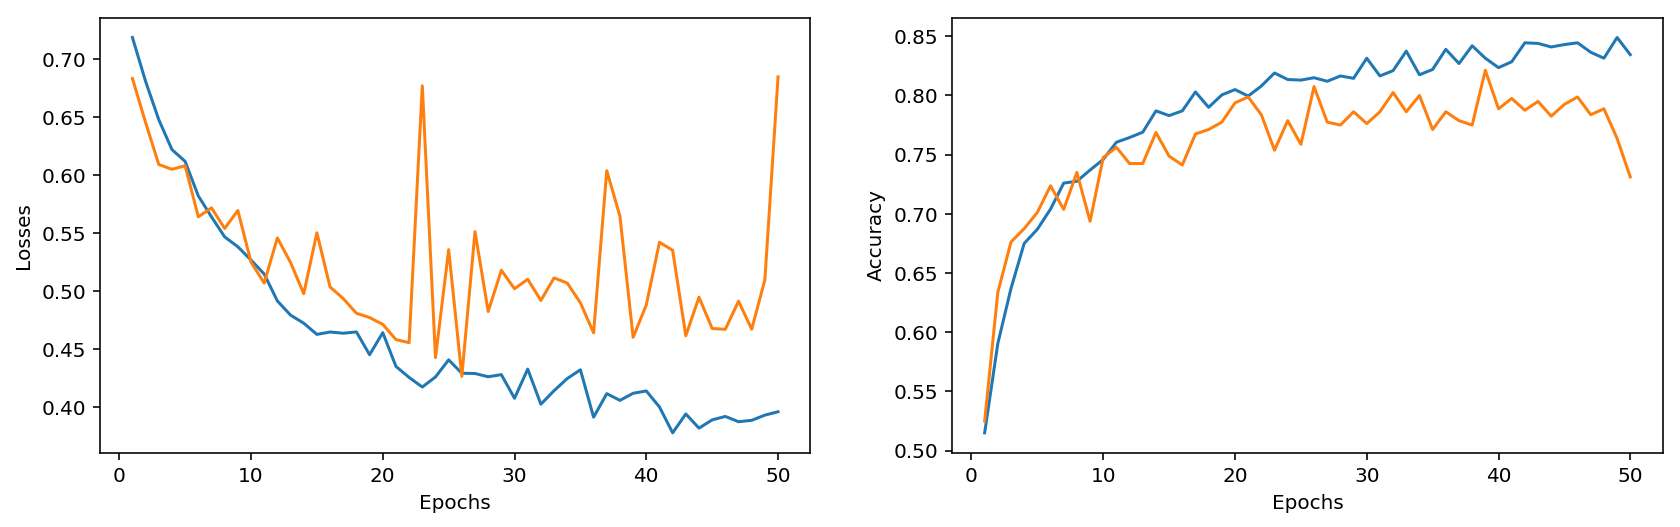

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
ax[0].plot(range(1, epochs + 1), history['loss'])
ax[0].plot(range(1, epochs + 1), history['val_loss'])
_ = ax[0].set(xlabel='Epochs', ylabel='Losses')
ax[1].plot(range(1, epochs + 1), history['acc'])
ax[1].plot(range(1, epochs + 1), history['val_acc'])
_ = ax[1].set(xlabel='Epochs', ylabel='Accuracy')

## Using the bottleneck features of a pre-trained network: 90% accuracy in a minute

In [1]:
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns

# this allows plots to appear directly in the notebook
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

from keras import applications

from keras import backend as K

from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [5]:
# dimensions of our images.
img_width, img_height = 150, 150

In [6]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [7]:
train_data_dir = 'data/cats-vs-dogs/sample/train'
validation_data_dir = 'data/cats-vs-dogs/sample/valid'

In [8]:
nb_train_samples = 2000
nb_validation_samples = 800

epochs = 50
batch_size = 16

In [46]:
def save_bottlebeck_features():
    datagen = ImageDataGenerator(rescale=1. / 255)

    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None, # this means our generator will only yield batches of data, no labels
        shuffle=False) # our data will be in order, so all first 1000 images will be cats, then 1000 dogs
    
    # the predict_generator method returns the output of a model, given
    # a generator that yields batches of numpy data
    bottleneck_features_train = model.predict_generator(
        generator, nb_train_samples // batch_size)
    
    # save the output as a Numpy array
    np.save(open('model_features/bottleneck_features_train.npy', 'wb'),
            bottleneck_features_train)

    generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    
    bottleneck_features_validation = model.predict_generator(
        generator, nb_validation_samples // batch_size)
    
    np.save(open('model_features/bottleneck_features_validation.npy', 'wb'),
            bottleneck_features_validation)

In [52]:
def train_top_model():
    train_data = np.load(open('model_features/bottleneck_features_train.npy', 'rb'))
    # the features were saved in order, so recreating the labels is easy
    train_labels = np.array(
        [0] * int((nb_train_samples / 2)) + [1] * int((nb_train_samples / 2)))

    validation_data = np.load(open('model_features/bottleneck_features_validation.npy', 'rb'))
    validation_labels = np.array(
        [0] * int((nb_validation_samples / 2)) + [1] * int((nb_validation_samples / 2)))

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy', metrics=['accuracy'])

    model.fit(train_data, train_labels,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(validation_data, validation_labels))
    
    model.save_weights('model_weights/bottleneck_fc_model.h5')

In [48]:
save_bottlebeck_features()

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [53]:
train_top_model()

Train on 2000 samples, validate on 800 samples
Epoch 1/50
2000/2000 [==============================] - 1s 615us/step - loss: 0.7667 - acc: 0.7510 - val_loss: 0.3415 - val_acc: 0.8413
Epoch 2/50
2000/2000 [==============================] - 1s 424us/step - loss: 0.3860 - acc: 0.8315 - val_loss: 0.2971 - val_acc: 0.8612
Epoch 3/50
2000/2000 [==============================] - 1s 417us/step - loss: 0.3283 - acc: 0.8665 - val_loss: 0.9397 - val_acc: 0.7037
Epoch 4/50
2000/2000 [==============================] - 1s 417us/step - loss: 0.2904 - acc: 0.8835 - val_loss: 0.2595 - val_acc: 0.8900
Epoch 5/50
2000/2000 [==============================] - 1s 414us/step - loss: 0.2440 - acc: 0.9025 - val_loss: 0.2622 - val_acc: 0.9000
Epoch 6/50
2000/2000 [==============================] - 1s 412us/step - loss: 0.1949 - acc: 0.9180 - val_loss: 0.2721 - val_acc: 0.9038
Epoch 7/50
2000/2000 [==============================] - 1s 413us/step - loss: 0.2133 - acc: 0.9220 - val_loss: 0.2995 - val_acc: 0.8975
E

## Fine-tuning the top layers of a a pre-trained network

In [9]:
from keras.models import Sequential
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

from keras import backend as K

from keras import applications
from keras import optimizers

from keras.preprocessing.image import ImageDataGenerator

In [10]:
# dimensions of our images.
img_width, img_height = 150, 150

In [11]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [12]:
train_data_dir = 'data/cats-vs-dogs/sample/train'
validation_data_dir = 'data/cats-vs-dogs/sample/valid'

In [13]:
nb_train_samples = 2000
nb_validation_samples = 800

epochs = 50
batch_size = 16

In [14]:
top_model_weights_path = 'model_weights/bottleneck_fc_model.h5'

In [15]:
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

In [25]:
# build the VGG16 network
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
#model = applications.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# build a classifier model to put on top of the convolutional model
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))

# note that it is necessary to start with a fully-trained
# classifier, including the top classifier,
# in order to successfully do fine-tuning
top_model.load_weights(top_model_weights_path)

# add the model on top of the convolutional base
#model.add(top_model)
model = Model(inputs=base_model.input, outputs=top_model(base_model.output))

# set the first 25 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in model.layers[:15]:
    layer.trainable = False

# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

model.summary()

# fine-tune the model
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    verbose=2)

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
___________________________________________________________